In [1]:
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [113]:
def connect_db(server, database, username, password):
    """
    Establish a connection to the MSSQL database.

    Parameters:
        server (str): The name of the MSSQL server.
        database (str): The name of the MSSQL database.
        username (str): The username for the MSSQL database.
        password (str): The password for the MSSQL database.

    Returns:
        pyodbc.Connection: The connection object to the MSSQL database.
    """
    conn = pyodbc.connect(driver='{ODBC Driver 17 for SQL Server}', server=server, database=database, uid=username,
                          pwd=password,
                          trusted_connection='yes')
    return conn

def fetch_data(query, conn):
    """
    Fetch data from the database and return it as a pandas DataFrame.

    Parameters:
        query (str): The SQL query to execute.
        conn (pyodbc.Connection): The connection object to the MSSQL database.
        
    Returns:
        pandas.DataFrame: The fetched data.
    """
    return pd.read_sql(query, conn)

def identify_dates(dates):
    """
    Identify dates.

    Parameters:
        dates (list): A sorted list of datetime.date objects.
        
    Returns:
        list: A list of tuples representing dates.
    """
    ranges = []
    current_range = [dates[0]]

    for i in range(1, len(dates)):
        if (dates[i] - dates[i-1]).days > 1:
            current_range.append(dates[i-1])
            ranges.append(current_range)
            current_range = [dates[i]]
    current_range.append(dates[-1])
    ranges.append(current_range)

    return ranges

def plot_dates(date_ranges_df):
    """
    Plot race dates to visualize continuous periods and gaps.

    Parameters:
        date_ranges_df (pandas.DataFrame): A DataFrame containing date ranges with 'Start' and 'End' columns.
    """
    fig, ax = plt.subplots(figsize=(10, 6))

    for index, row in date_ranges_df.iterrows():
        ax.plot([row['Start'], row['End']], [index, index], marker='o')

    ax.set_title('Dates of recorded races')
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of recoded race')
    ax.grid(True)

    plt.show()

def plot_races_per_year(races_per_year_df):
    """
    Plot the number of races per year.

    Parameters:
        races_per_year_df (pandas.DataFrame): A DataFrame containing 'Year' and 'RaceCount' columns.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(races_per_year_df['Year'], races_per_year_df['RaceCount'], marker='o')
    plt.title('Number of Races per Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Races')
    plt.grid(True)
    plt.show()

def plot_points_per_nationality(points_by_nationality_df):
    """
    Plot total points by driver nationality.

    Parameters:
        points_by_nationality_df (pandas.DataFrame): A DataFrame containing 'TotalPoints' and 'Nationality' columns.
    """
    plt.figure(figsize=(12, 8))
    sns.barplot(x='TotalPoints', y='Nationality', data=points_by_nationality_df)
    plt.title('Total Points by Driver Nationality')
    plt.xlabel('Total Points')
    plt.ylabel('Nationality')
    plt.show()

def plot_races_per_circuit(races_per_circuit_df):
    """
    Plot the number of races per circuit.

    Parameters:
        races_per_circuit_df (pandas.DataFrame): A DataFrame containing 'CircuitName' and 'RaceCount' columns.
    """
    fig = px.bar(races_per_circuit_df, x='CircuitName', y='RaceCount', title='Number of Races per Circuit')
    fig.show()

def plot_stacked_bar_chart(winners_df, entity, entity_name):
    """
    Plot a stacked bar chart with total number of races and wins per season.

    Parameters:
        winners_df (pandas.DataFrame): A DataFrame containing race wins data.
        entity (str): The column name representing the entity (e.g., 'Driver' or 'Constructor').
        entity_name (str): The name of the entity to display in the chart.
    """
    unique_seasons = winners_df['Season'].unique()
    total_races_per_season = winners_df[['Season', 'TotalRaces']].drop_duplicates().set_index('Season')
    winners_per_season = winners_df.groupby(['Season', entity_name])['Wins'].sum().unstack().fillna(0)

    # Calculate the remaining races not won by the given entity
    remaining_races = total_races_per_season['TotalRaces'] - winners_per_season.sum(axis=1)

    # Add remaining races as a separate row
    winners_per_season['Others'] = remaining_races

    # Plot stacked bar chart
    ax = winners_per_season.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')

    plt.xlabel('Season')
    plt.ylabel('Number of Wins')
    plt.title(f'Number of Wins per {entity} per Season (Stacked)')
    plt.xticks(rotation=90)
    plt.legend(title=entity_name)
    plt.grid(axis='y')
    
    plt.show()

def plot_winners_per_season(winners_df, entity, entity_name):
    """
    Plot number of wins per season for each driver/constructor.

    Parameters:
        winners_df (pandas.DataFrame): A DataFrame containing race wins data.
        entity (str): The column name representing the entity (e.g., 'Driver' or 'Constructor').
        entity_name (str): The name of the entity to display in the chart.
    """
    unique_seasons = winners_df['Season'].unique()
    num_seasons = len(unique_seasons)
    
    fig, axes = plt.subplots(num_seasons, 1, figsize=(8, num_seasons * 2), sharex=True)
    
    for i, season in enumerate(unique_seasons):
        season_df = winners_df[winners_df['Season'] == season]
        sns.barplot(ax=axes[i], x='Wins', y=entity_name, hue=entity_name, data=season_df, palette='viridis')
        axes[i].set_title(f'{entity} Wins in {season}')
        axes[i].set_xlabel('Number of Wins')
        axes[i].set_ylabel(entity_name)
    
    plt.tight_layout()
    plt.show()

In [114]:
# Database connection parameters
server = 'localhost'
database = 'FDB'
username = 'FormulaUser'
password = 't6sg7KdgZ7a1aFds3'

# Establish the database connection
conn = connect_db(server, database, username, password)

# Fetch data for visualizations
# Query to get the number of races per year
query_races_per_year = """
SELECT YEAR(r_date) as Year, COUNT(*) as RaceCount
FROM race
GROUP BY YEAR(r_date)
ORDER BY Year
"""
races_per_year_df = fetch_data(query_races_per_year, conn)

# Query to get the total points scored by drivers from different nationalities
query_points_by_nationality = """
SELECT driver.d_nationality AS Nationality, SUM(result.res_points) as TotalPoints
FROM result
JOIN driver ON result.res_fk_d_id = driver.d_id
GROUP BY driver.d_nationality
"""
points_by_nationality_df = fetch_data(query_points_by_nationality, conn)

# Query to get the number of races held at each circuit
query_races_per_circuit = """
SELECT circuit.c_name AS CircuitName, COUNT(*) as RaceCount
FROM race
JOIN circuit ON race.r_fk_c_id = circuit.c_id
GROUP BY circuit.c_name
"""
races_per_circuit_df = fetch_data(query_races_per_circuit, conn)

# Query to get all race dates in chronological order
query_race_dates = "SELECT r_date AS Date FROM race ORDER BY Date"
race_dates_df = fetch_data(query_race_dates, conn)

# Fetch data for the number of wins per season for each driver and constructor
query_winners = """
SELECT
    YEAR(race.r_date) as Season,
    driver.d_id AS DriverID,
    driver.d_firstname AS FirstName,
    driver.d_surname AS LastName,
    constructor.con_id AS ConstructorID,
    constructor.con_name AS ConstructorName,
    COUNT(result.res_position) as Wins
FROM result
JOIN race ON result.res_fk_r_id = race.r_id
JOIN driver ON result.res_fk_d_id = driver.d_id
JOIN constructor ON result.res_fk_con_id = constructor.con_id
WHERE result.res_position = 1
GROUP BY YEAR(race.r_date), driver.d_id, driver.d_firstname, driver.d_surname, constructor.con_id, constructor.con_name
ORDER BY Season, Wins DESC
"""
winners_df = fetch_data(query_winners, conn)

# Concatenate first name and last name to create a full name for the driver
winners_df['DriverName'] = winners_df['FirstName'] + ' ' + winners_df['LastName']

# Fetch total number of races per season
query_total_races = """
SELECT
    YEAR(race.r_date) as Season,
    COUNT(*) as TotalRaces
FROM race
GROUP BY YEAR(race.r_date)
ORDER BY YEAR(race.r_date)
"""
total_races_df = fetch_data(query_total_races, conn)

# Merge the wins data with the total races data to get a complete dataset for plotting
dominance_df = pd.merge(winners_df, total_races_df, on='Season')

# Close the connection
conn.close()

C:\Users\Admin\AppData\Local\Temp\ipykernel_28848\1818737534.py:30: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

C:\Users\Admin\AppData\Local\Temp\ipykernel_28848\1818737534.py:30: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



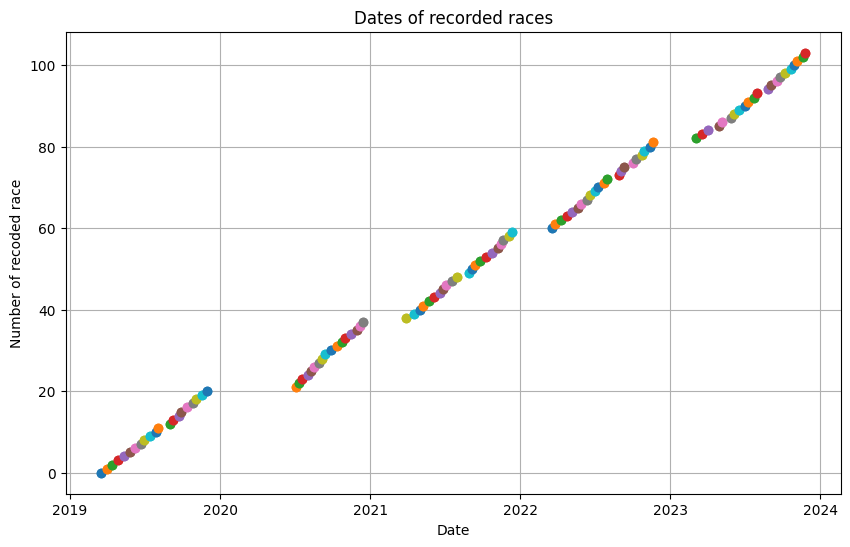

In [115]:
race_dates_df['Date'] = pd.to_datetime(race_dates_df['Date'])

# Identify dates
date_ranges = identify_dates(race_dates_df['Date'].sort_values().tolist())

# Convert date ranges to a DataFrame for easier plotting
date_ranges_df = pd.DataFrame(date_ranges, columns=['Start', 'End'])

# Plot the date ranges
plot_dates(date_ranges_df)

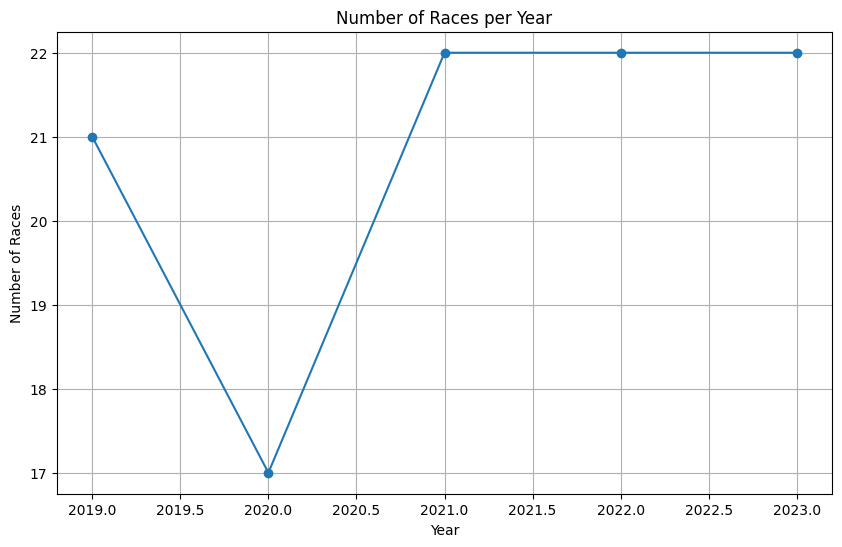

In [116]:
# Plot the number of races per year
plot_races_per_year(races_per_year_df)

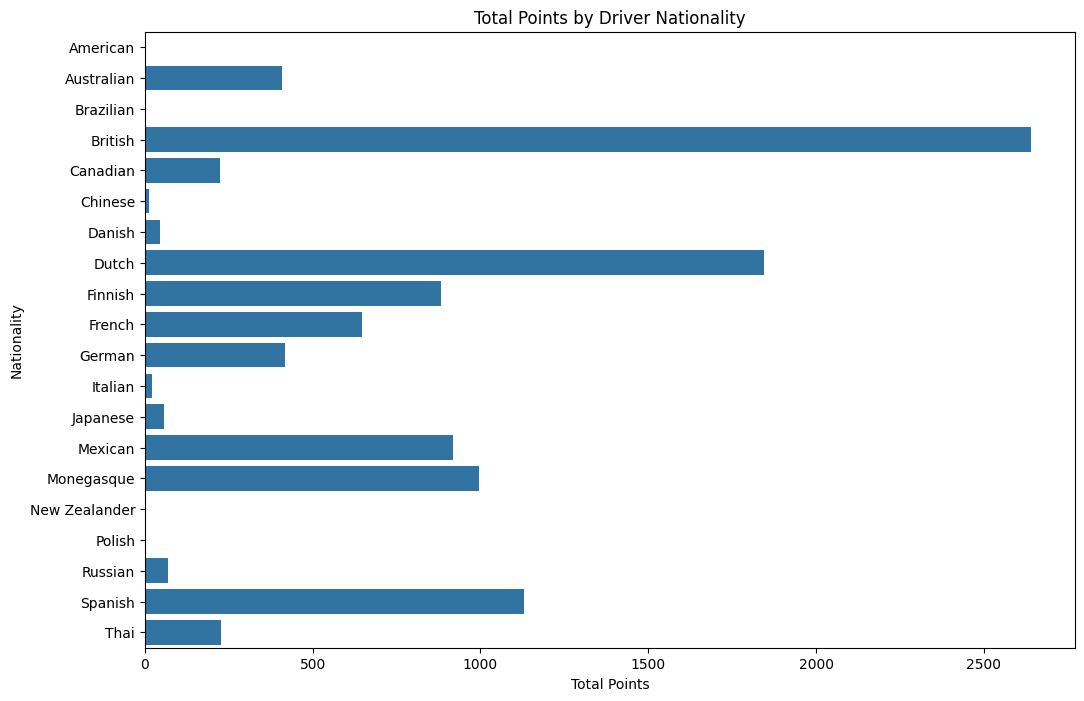

In [117]:
# Plot the points per nationality
plot_points_per_nationality(points_by_nationality_df)

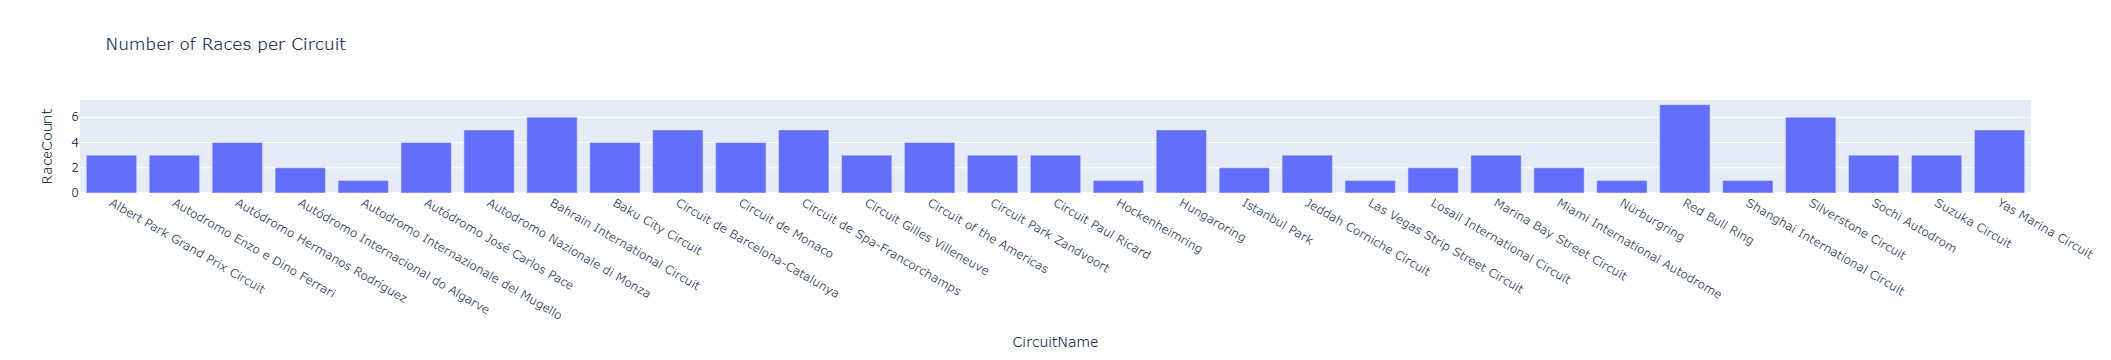

In [118]:
# Plot the races per circuit
plot_races_per_circuit(races_per_circuit_df)

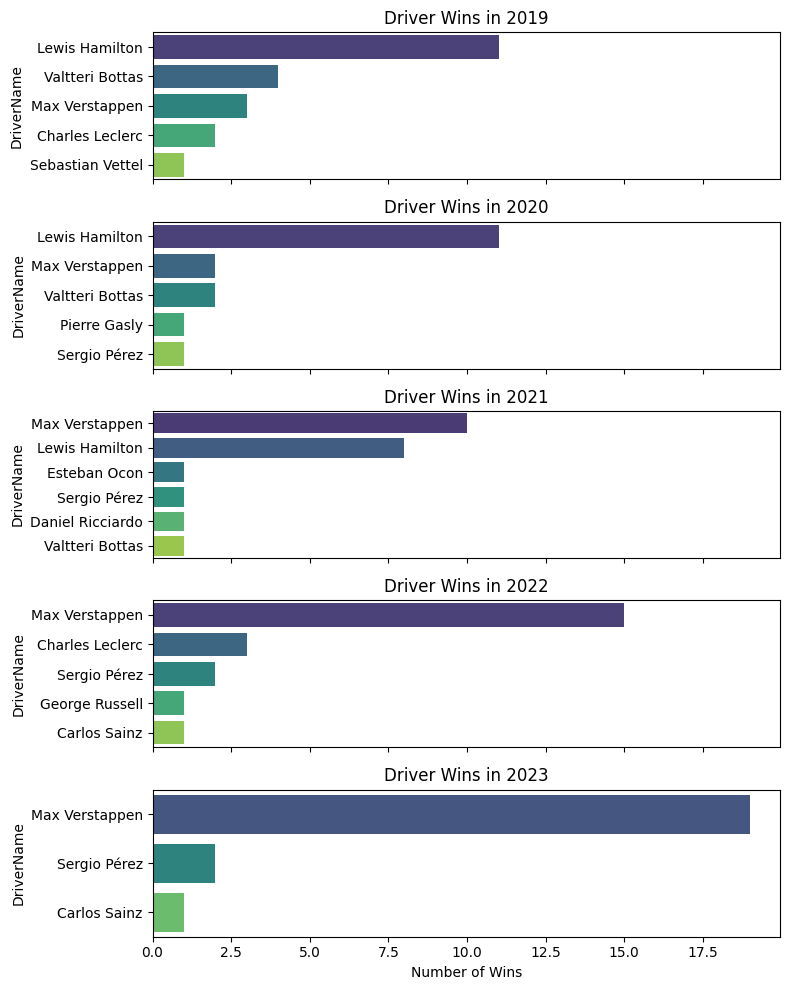

In [119]:
# Plot race winners per season
plot_winners_per_season(winners_df[['Season', 'DriverName', 'Wins']], 'Driver', 'DriverName')

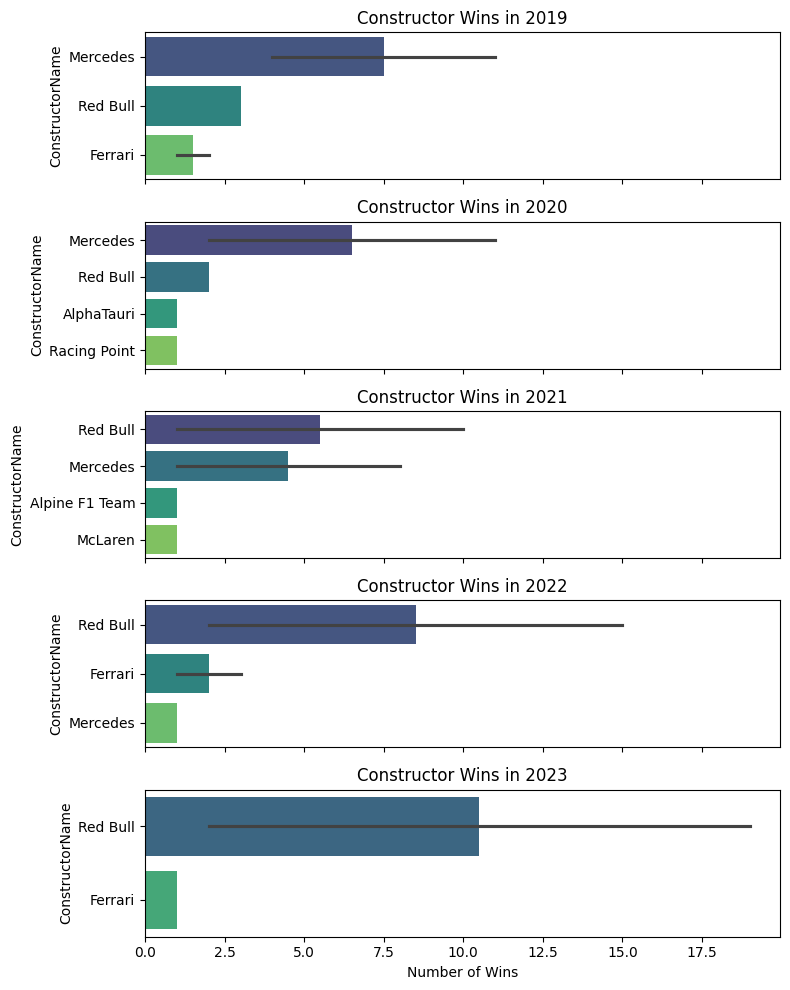

In [120]:
# Plot winning constructors per season
plot_winners_per_season(winners_df[['Season', 'ConstructorName', 'Wins']], 'Constructor', 'ConstructorName')

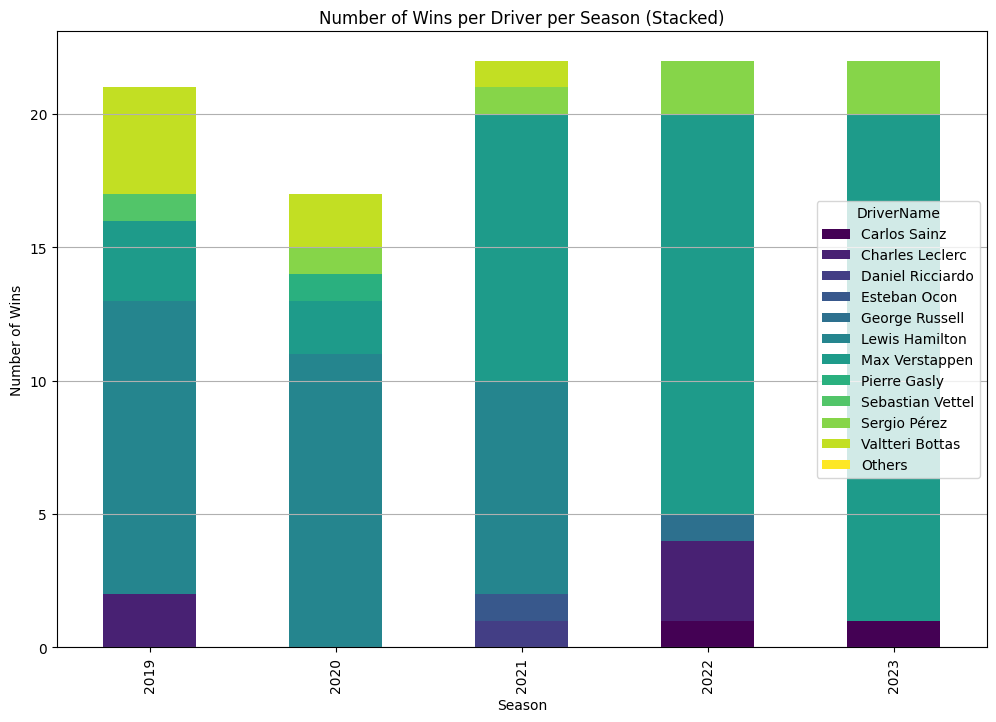

In [121]:
# Plot the driver wins as stacked bar charts to show the dominance of the championship winning driver.
plot_stacked_bar_chart(dominance_df, 'Driver', 'DriverName')

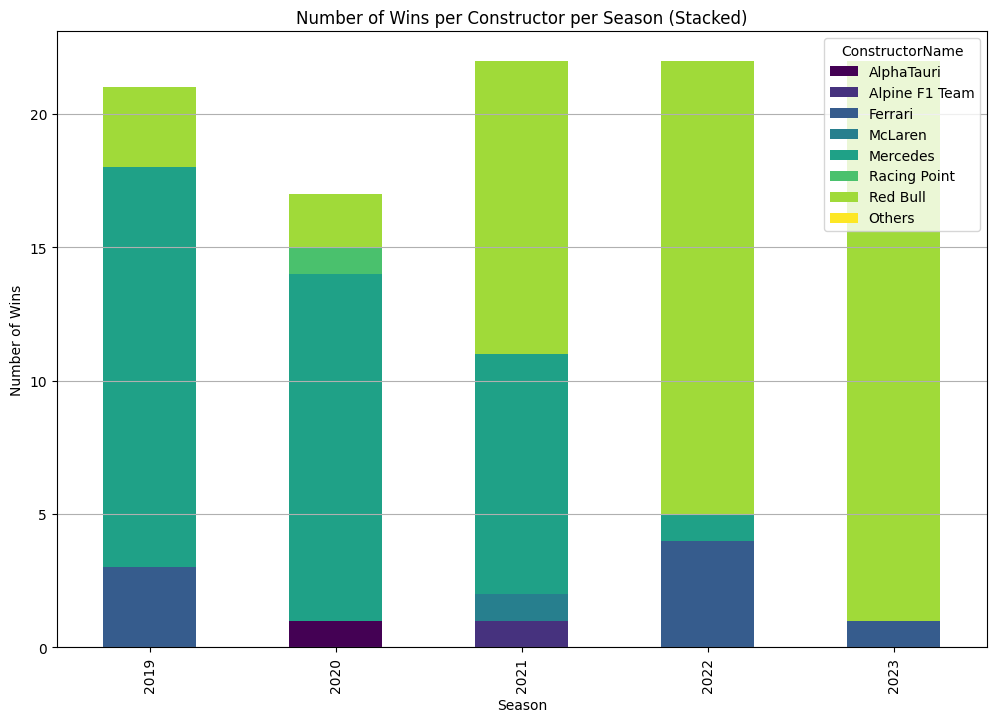

In [122]:
# Plot the constructor wins as stacked bar charts to show the dominance of the championship winning team.
plot_stacked_bar_chart(dominance_df, 'Constructor', 'ConstructorName')